***Rhea Chainani | 22070126086 | AIML B1***

## Installing Dependencies

In [1]:
pip install torch torchvision torchsummary medmnist tensorboard tqdm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch-fidelity --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchmetrics[image] --quiet

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import medmnist
from medmnist import BreastMNIST
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from tqdm import tqdm

In [5]:
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [6]:
from torch.cuda.amp import autocast, GradScaler

In [7]:
# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load MedMNIST Dataset

**BreastMNIST** is a medical imaging dataset from the **MedMNIST** collection, consisting of **28×28 grayscale images** derived from breast ultrasound scans. It includes a total of **780 images**, categorized into **two classes**—benign and malignant—making it suitable for binary classification tasks. The dataset is split into training (546 images), validation (78 images), and test (156 images) sets. BreastMNIST serves as a benchmark for developing and evaluating deep learning models in breast cancer detection, aiding in automated diagnostics and medical image analysis research.

In [8]:
# Define dataset transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1] for better GAN performance
])

In [9]:
# Load the MedMNIST dataset (BreastMNIST)
root_dir = "/kaggle/working/medmnist_data"
os.makedirs(root_dir, exist_ok=True)

dataset = BreastMNIST(root=root_dir, split="train", transform=transform, download=True, as_rgb=False)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print("Dataset loaded successfully!")

100%|██████████| 560k/560k [00:00<00:00, 859kB/s] 

Dataset loaded successfully!


## Define Generator & Discriminator

In [10]:
class Generator(nn.Module):
    """
    Generator Network for GANs.
    Generates synthetic images from random noise (latent vector).
    """
    def __init__(self, latent_dim=100, img_shape=(1, 28, 28)):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, int(np.prod(img_shape))),  # Output flattened image
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, z):
        """
        Forward pass: Generates an image from latent vector z.
        """
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)  # Reshape to image format
        return img

In [11]:
class Discriminator(nn.Module):
    """
    Discriminator Network for GANs.
    Determines whether an image is real or fake.
    """
    def __init__(self, img_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)  # Output single score (real or fake)
        )

    def forward(self, img):
        """
        Forward pass: Classifies an image as real or fake.
        """
        img_flat = img.view(img.size(0), -1)  # Flatten image
        return self.model(img_flat)

In [12]:
def save_generated_images(generator, epoch, latent_dim=100, num_images=16, gan_type="WGAN", base_folder="generated_images"):
    folder = os.path.join(base_folder, gan_type)  # Separate folders per GAN type
    os.makedirs(folder, exist_ok=True)  

    z = torch.randn(num_images, latent_dim).to(device)
    with torch.no_grad():
        fake_imgs = generator(z)

    image_path = f"{folder}/epoch_{epoch}.png"
    vutils.save_image(fake_imgs, image_path, normalize=True)
    
    print(f"Saved: {image_path}")

In [13]:
def evaluate_performance(generator, inception, fid, latent_dim, num_images=100):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(next(generator.parameters()).device)
        fake_imgs = generator(z)
        
    fake_imgs = (fake_imgs + 1) * 127.5  # Convert from [-1,1] to [0,255]
    fake_imgs = fake_imgs.clamp(0, 255).to(torch.uint8)  # Ensure values are within 0-255 and convert to uint8
    
    inception.update(fake_imgs.repeat(1, 3, 1, 1))
    fid.update((fake_imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=False)
    generator.train()

## Define Training Functions

### LS-GAN Training

LSGAN replaces the binary cross-entropy loss used in standard GANs with a **least squares loss function** to stabilize training. By minimizing the **mean squared error** between real and fake labels, LSGAN reduces mode collapse and produces smoother gradients, leading to more realistic image generation.
But it is still susceptible to mode collapse and vanishing gradients.

In [14]:
def train_ls_gan(generator, discriminator, dataloader, epochs=100, latent_dim=100):
    """
    Trains a Least Squares GAN (LS-GAN).
    """
    writer = SummaryWriter(log_dir="./logs/LSGAN")
    criterion = nn.MSELoss()  # Least Squares loss
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)

    for epoch in range(epochs):
        fid.reset()  # Reset FID at the beginning of each epoch

        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)
            
            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()
            
            real_preds = discriminator(imgs)
            fake_preds = discriminator(fake_imgs)

            real_loss = criterion(real_preds, torch.ones_like(real_preds))
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
            
            d_loss = 0.5 * (real_loss + fake_loss)
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            gen_imgs = generator(z)
            
            g_loss = criterion(discriminator(gen_imgs), torch.ones_like(discriminator(gen_imgs)))
            g_loss.backward()
            optimizer_G.step()

            # Update FID with real & fake images
            fid.update((imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=True)  # Convert grayscale to 3-channel
            fid.update((fake_imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=False)

        # Compute FID only if enough samples exist
        if fid.real_features_num_samples > 1 and fid.fake_features_num_samples > 1:
            fid_score = fid.compute().item()
        else:
            fid_score = float("inf")  # Placeholder until enough samples accumulate

        if epoch % 5 == 0 or epoch == epochs-1:
            save_generated_images(generator, epoch, latent_dim, gan_type="LSGAN")
            evaluate_performance(generator, inception, fid, latent_dim)

            # Generate sample images for TensorBoard
            z = torch.randn(25, latent_dim).to(device)  
            sample_imgs = generator(z).detach().cpu()
            writer.add_images(f"Generated Images", sample_imgs.repeat(1, 3, 1, 1), epoch)

            inception_score = inception.compute()[0].item()
            writer.add_scalar("Inception Score", inception_score, epoch)
            writer.add_scalar("FID Score", fid_score, epoch)

        writer.add_scalar("D Loss", d_loss.item(), epoch)
        writer.add_scalar("G Loss", g_loss.item(), epoch)

        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | FID: {fid_score:.3f}")

### WGAN Training

WGAN improves training stability by using the **Wasserstein distance (Earth Mover’s distance)** instead of the Jensen-Shannon divergence. It replaces the discriminator with a **critic**, which does not classify but rather **scores** real and fake samples. **Weight clipping** is applied to enforce the Lipschitz constraint. But one of its disadvantages is that weight clipping can limit learning capacity.



In [15]:
def train_wgan(generator, discriminator, dataloader, epochs=100, latent_dim=100, c=0.01):
    """
    Trains a Wasserstein GAN (WGAN) with weight clipping.
    """
    writer = SummaryWriter(log_dir="./logs/WGAN")
    optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
    optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)
    
    for epoch in range(epochs):
        fid.reset()
        
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()
            
            d_loss = -(discriminator(imgs).mean() - discriminator(fake_imgs).mean())
            d_loss.backward()
            optimizer_D.step()

            # Apply weight clipping
            for p in discriminator.parameters():
                p.data.clamp_(-c, c)

            # Update FID
            fid.update((imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=True)
            fid.update((fake_imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=False)
        
            # Train Generator (every 5 steps)
            if i % 5 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(imgs.size(0), latent_dim).to(device)
                g_loss = -discriminator(generator(z)).mean()
                g_loss.backward()
                optimizer_G.step()

        if epoch % 5 == 0 or epoch == epochs-1:
            save_generated_images(generator, epoch, latent_dim)
            evaluate_performance(generator, inception, fid, latent_dim)
            inception_score = inception.compute()[0].item()
            fid_score = fid.compute().item()
            writer.add_scalar("Inception Score", inception_score, epoch)
            writer.add_scalar("FID Score", fid_score, epoch)
            # Generate sample images for TensorBoard
            z = torch.randn(25, latent_dim).to(device)  # Generate 25 images
            sample_imgs = generator(z).detach().cpu()
            writer.add_images(f"Generated Images", sample_imgs.repeat(1, 3, 1, 1), epoch)
        
        writer.add_scalar("D Loss", d_loss.item(), epoch)
        writer.add_scalar("G Loss", g_loss.item(), epoch)
        
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | FID: {fid_score:.3f}")

### WGAN-GP Training

WGAN-GP enhances WGAN by replacing weight clipping with a **gradient penalty**, enforcing the Lipschitz constraint more effectively. This eliminates the need for manual weight clipping and results in smoother and more realistic generated samples. But it incurrs a higher computational cost due to gradient penalty computation.

In [16]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """
    Computes the gradient penalty for WGAN-GP.
    """
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty

In [17]:
def train_wgan_gp(generator, discriminator, dataloader, epochs=100, latent_dim=100, lambda_gp=10):
    """
    Trains a Wasserstein GAN with Gradient Penalty (WGAN-GP).
    """
    writer = SummaryWriter(log_dir="./logs/WGAN-GP")
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.9))

    inception = InceptionScore().to(device)
    fid = FrechetInceptionDistance().to(device)

    for epoch in range(epochs):
        fid.reset()
        
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(device)

            optimizer_D.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            fake_imgs = generator(z).detach()
            
            gp = compute_gradient_penalty(discriminator, imgs, fake_imgs)
            d_loss = -(discriminator(imgs).mean() - discriminator(fake_imgs).mean()) + lambda_gp * gp
            d_loss.backward()
            optimizer_D.step()

            # Update FID
            fid.update((imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=True)
            fid.update((fake_imgs.repeat(1, 3, 1, 1) * 255).to(torch.uint8), real=False)
        
            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).to(device)
            g_loss = -discriminator(generator(z)).mean()
            g_loss.backward()
            optimizer_G.step()

        if epoch % 5 == 0 or epoch == epochs-1:
            save_generated_images(generator, epoch, latent_dim, gan_type="WGAN-GP")
            evaluate_performance(generator, inception, fid, latent_dim)
            inception_score = inception.compute()[0].item()
            fid_score = fid.compute().item()
            writer.add_scalar("Inception Score", inception_score, epoch)
            writer.add_scalar("FID Score", fid_score, epoch)
            # Generate sample images for TensorBoard
            z = torch.randn(25, latent_dim).to(device)  # Generate 25 images
            sample_imgs = generator(z).detach().cpu()
            writer.add_images(f"Generated Images", sample_imgs.repeat(1, 3, 1, 1), epoch)
    
        writer.add_scalar("D Loss", d_loss.item(), epoch)
        writer.add_scalar("G Loss", g_loss.item(), epoch)
        
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}  | FID: {fid_score:.3f}")

#### Train all three GANs

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [19]:
import shutil

def reset_generated_images(folder="generated_images"):
    """Deletes the folder if it exists, then recreates it."""
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder
    os.makedirs(folder, exist_ok=True)  # Recreate it
    print(f"Reset {folder} before training.")

reset_generated_images()

Reset generated_images before training.


In [20]:
train_ls_gan(generator, discriminator, dataloader)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 385MB/s]


Saved: generated_images/LSGAN/epoch_0.png
Epoch 1/100 | D Loss: 0.2263 | G Loss: 0.3651 | FID: 425.686
Epoch 2/100 | D Loss: 0.0781 | G Loss: 1.0944 | FID: 443.453
Epoch 3/100 | D Loss: 0.1402 | G Loss: 0.7312 | FID: 440.778
Epoch 4/100 | D Loss: 0.1586 | G Loss: 0.7723 | FID: 421.658
Epoch 5/100 | D Loss: 0.0950 | G Loss: 1.2423 | FID: 400.346
Saved: generated_images/LSGAN/epoch_5.png
Epoch 6/100 | D Loss: 0.0461 | G Loss: 1.9309 | FID: 374.304
Epoch 7/100 | D Loss: 0.0857 | G Loss: 2.2301 | FID: 372.255
Epoch 8/100 | D Loss: 0.0605 | G Loss: 2.3622 | FID: 372.237
Epoch 9/100 | D Loss: 0.0330 | G Loss: 2.2357 | FID: 387.433
Epoch 10/100 | D Loss: 0.0496 | G Loss: 1.7566 | FID: 421.403
Saved: generated_images/LSGAN/epoch_10.png
Epoch 11/100 | D Loss: 0.0613 | G Loss: 1.6325 | FID: 432.877
Epoch 18/100 | D Loss: 0.0131 | G Loss: 1.1185 | FID: 402.572
Epoch 19/100 | D Loss: 0.0234 | G Loss: 1.1789 | FID: 402.883
Epoch 20/100 | D Loss: 0.0164 | G Loss: 1.1327 | FID: 405.485
Saved: generat

In [21]:
folder_name = "logs/LSGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/logs/LSGAN.zip

In [22]:
folder_name = "generated_images/LSGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/generated_images/LSGAN.zip

In [25]:
log_dir = '/kaggle/working/logs/LSGAN'
print("Log Directory Exists:", os.path.exists(log_dir))
print("Files in Log Directory:", os.listdir(log_dir) if os.path.exists(log_dir) else "No logs found")

Log Directory Exists: True
Files in Log Directory: ['events.out.tfevents.1743312644.e1c0faa0c87d.31.0']


**Generated Images**

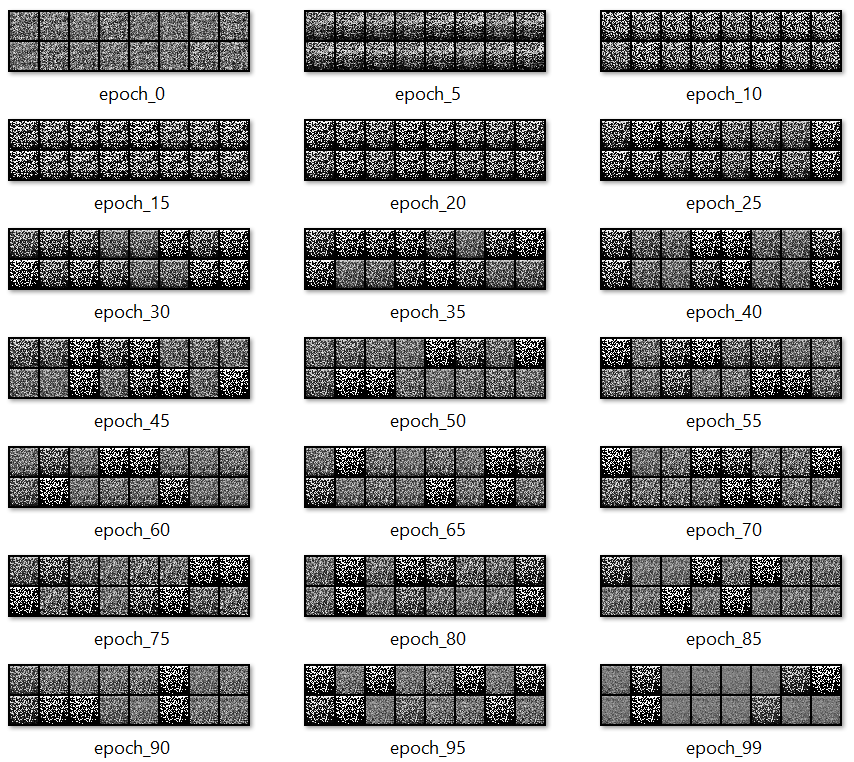

**Tensorboard Charts**

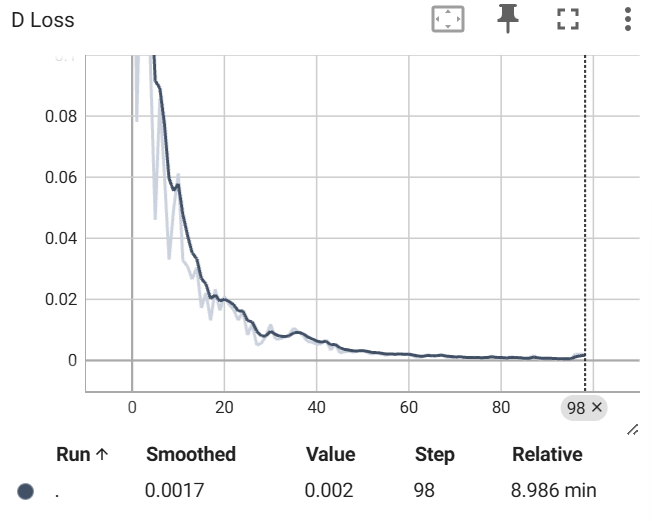

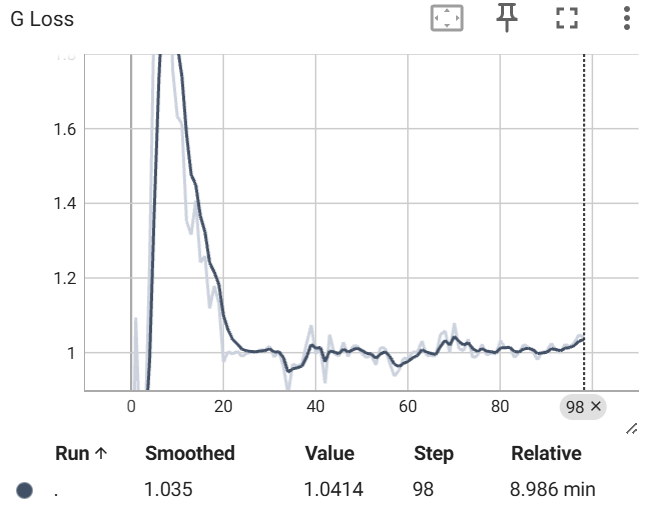

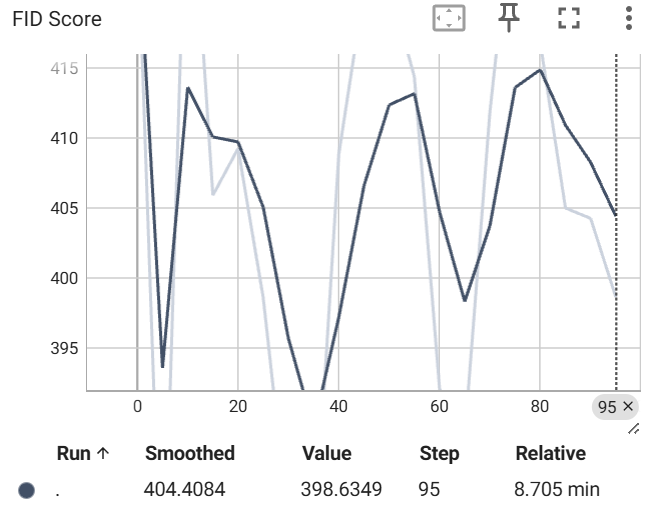

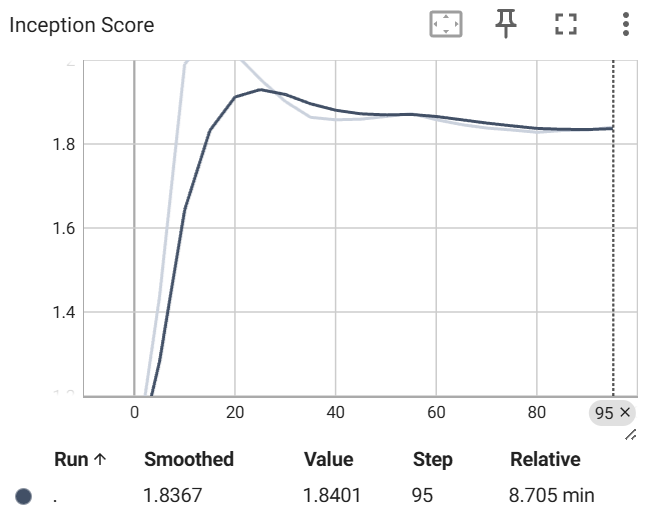

In [26]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# Path to logs folder
log_dir = "/kaggle/working/logs/LSGAN"

# Get the latest event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
event_files.sort()
event_file = os.path.join(log_dir, event_files[-1])  # Last event file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract FID and IS values
fid_values = event_acc.Scalars("FID Score") if "FID Score" in event_acc.Tags()['scalars'] else []
is_values = event_acc.Scalars("Inception Score") if "Inception Score" in event_acc.Tags()['scalars'] else []

# Get the final recorded values
final_fid = fid_values[-1].value if fid_values else "Not Found"
final_is = is_values[-1].value if is_values else "Not Found"

print(f"Final FID: {final_fid}")
print(f"Final IS: {final_is}")

Final FID: 398.63494873046875
Final IS: 1.8400744199752808


A lower FID is better (ideal: ≤10 for high-quality images). Here, we have 398.63, which is quite high, meaning the generated images are **significantly different from real images** in terms of distribution.
This suggests that the LSGAN may still be generating **low-quality or unrealistic** images, and there might be **mode collapse or instability**.

A higher IS (ideal: >8 for high-quality images) means images are more diverse and contain meaningful objects.
1.84 is very low, indicating that the images **lack diversity** and do **not have clearly recognizable features**. This suggests that the generator is struggling to produce distinct, high-quality outputs.

Possible reasons include training instability, mode collapse, insufficient training or architecture issues.

Steps to improve include training for more epochs, tweaking the learning rate or using a better architecture (such as WGAN-GP or StyleGAN).

In [27]:
torch.save(generator.state_dict(), "generator_lsgan_bm100.pth")
torch.save(discriminator.state_dict(), "discriminator_lsgan_bm100.pth")

In [28]:
train_wgan(generator, discriminator, dataloader)

Saved: generated_images/WGAN/epoch_0.png
Epoch 1/100 | D Loss: -0.1224 | G Loss: 0.0359 | FID: 369.973
Epoch 2/100 | D Loss: -0.2631 | G Loss: 0.1015 | FID: 369.973
Epoch 3/100 | D Loss: -0.5374 | G Loss: 0.2135 | FID: 369.973
Epoch 4/100 | D Loss: -0.9437 | G Loss: 0.3527 | FID: 369.973
Epoch 5/100 | D Loss: -1.3279 | G Loss: 0.5345 | FID: 369.973
Saved: generated_images/WGAN/epoch_5.png
Epoch 6/100 | D Loss: -1.7223 | G Loss: 0.5859 | FID: 359.279
Epoch 7/100 | D Loss: -2.0012 | G Loss: 0.7244 | FID: 359.279
Epoch 8/100 | D Loss: -2.3699 | G Loss: 0.7688 | FID: 359.279
Epoch 9/100 | D Loss: -2.3656 | G Loss: 0.5648 | FID: 359.279
Epoch 10/100 | D Loss: -2.4944 | G Loss: 0.7089 | FID: 359.279
Saved: generated_images/WGAN/epoch_10.png
Epoch 11/100 | D Loss: -2.5190 | G Loss: 0.5003 | FID: 342.077
Epoch 12/100 | D Loss: -2.2900 | G Loss: 0.2877 | FID: 342.077
Epoch 13/100 | D Loss: -2.2314 | G Loss: -0.1152 | FID: 342.077
Epoch 14/100 | D Loss: -2.0639 | G Loss: -0.3892 | FID: 342.077
E

In [29]:
folder_name = "logs/WGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/logs/WGAN.zip

In [30]:
folder_name = "generated_images/WGAN"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/generated_images/WGAN.zip

In [31]:
log_dir = "/kaggle/working/logs/WGAN"
print("Log Directory Exists:", os.path.exists(log_dir))
print("Files in Log Directory:", os.listdir(log_dir) if os.path.exists(log_dir) else "No logs found")

Log Directory Exists: True
Files in Log Directory: ['events.out.tfevents.1743313280.e1c0faa0c87d.31.1']


**Generated Images**

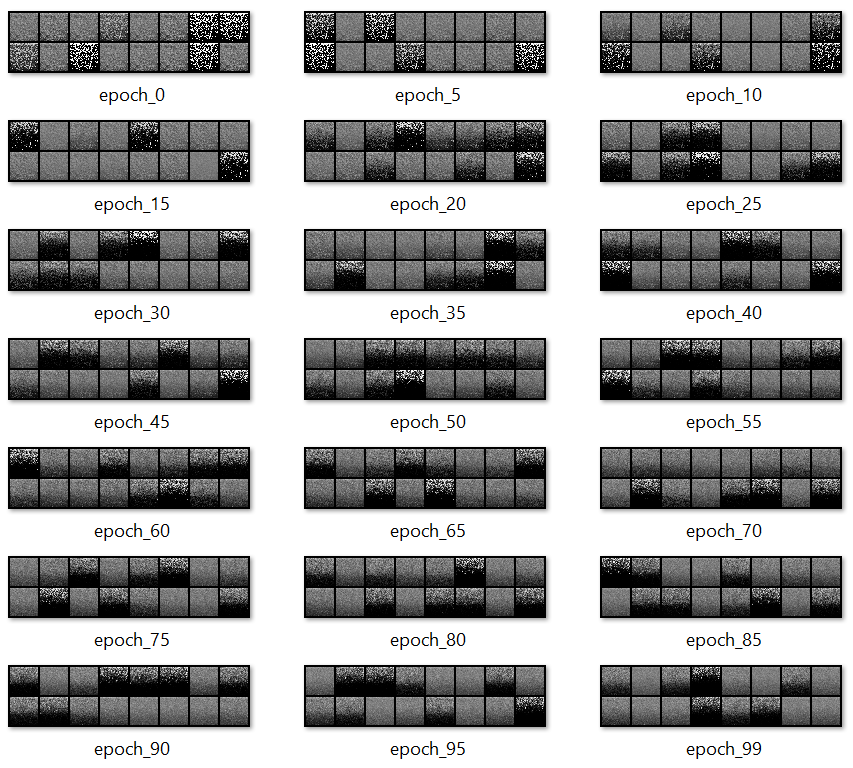

**Tensorboard Charts**

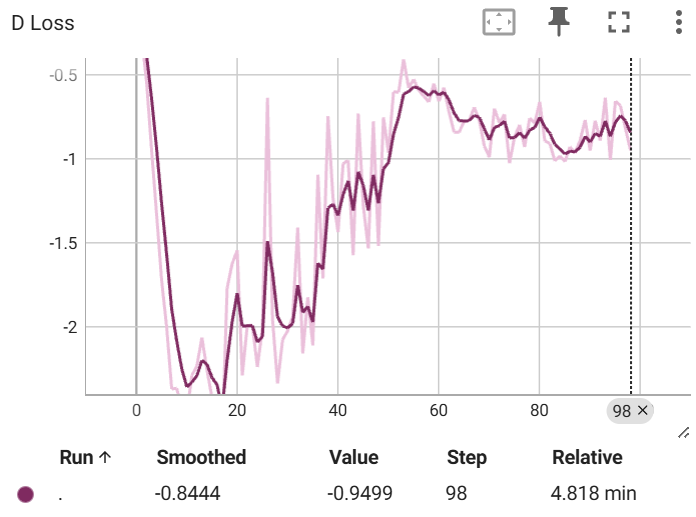

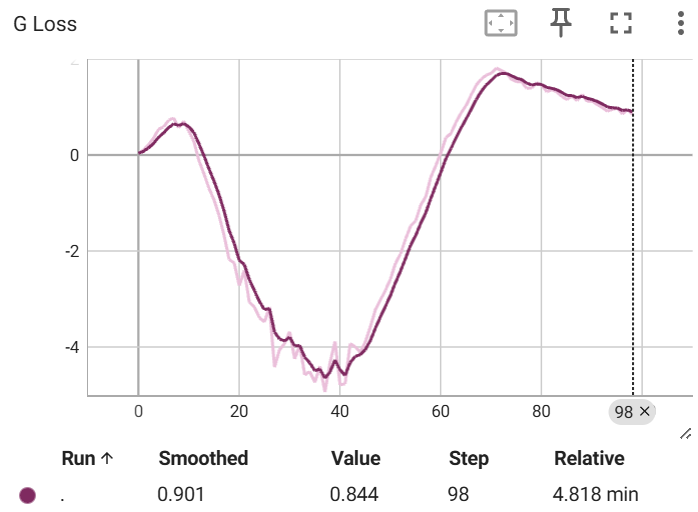

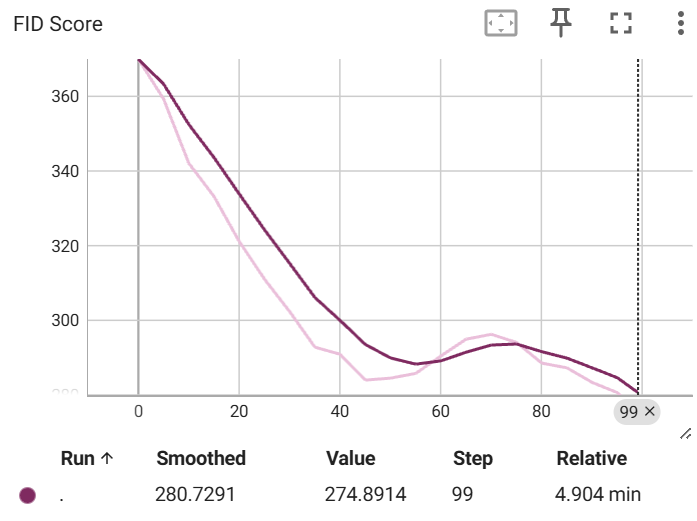

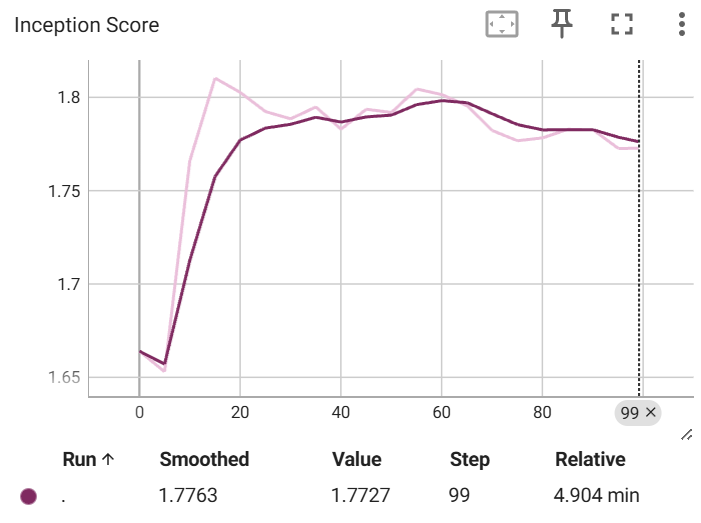

In [32]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [33]:
# Get the latest event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
event_files.sort()
event_file = os.path.join(log_dir, event_files[-1])  # Last event file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract FID and IS values
fid_values = event_acc.Scalars("FID Score") if "FID Score" in event_acc.Tags()['scalars'] else []
is_values = event_acc.Scalars("Inception Score") if "Inception Score" in event_acc.Tags()['scalars'] else []

# Get the final recorded values
final_fid = fid_values[-1].value if fid_values else "Not Found"
final_is = is_values[-1].value if is_values else "Not Found"

print(f"Final FID: {final_fid}")
print(f"Final IS: {final_is}")

Final FID: 274.8914489746094
Final IS: 1.7726986408233643


The **FID score of 274.89** suggests that the generated images are far from real, while the **Inception Score of 1.77** indicates low diversity and quality. But we could notice the **reducing FID** after each epoch, indicating the model's improvement. WGAN may need more training, better hyperparameters, or a stronger generator to improve results. Issues like weight clipping limitations or an overly strong discriminator could be affecting performance. Switching to **WGAN-GP**, increasing training epochs, or adjusting model architecture may help enhance image quality.

In [34]:
torch.save(generator.state_dict(), "generator_wgan_bm100.pth")
torch.save(discriminator.state_dict(), "discriminator_wgan_bm100.pth")

In [35]:
train_wgan_gp(generator, discriminator, dataloader)

Saved: generated_images/WGAN-GP/epoch_0.png
Epoch 1/100 | D Loss: 8.7801 | G Loss: 0.9090  | FID: 275.720
Epoch 2/100 | D Loss: 9.4376 | G Loss: 0.7607  | FID: 275.720
Epoch 3/100 | D Loss: 9.8497 | G Loss: 0.7253  | FID: 275.720
Epoch 4/100 | D Loss: 9.8313 | G Loss: 0.7400  | FID: 275.720
Epoch 5/100 | D Loss: 9.8205 | G Loss: 0.6753  | FID: 275.720
Saved: generated_images/WGAN-GP/epoch_5.png
Epoch 6/100 | D Loss: 9.9539 | G Loss: 0.3728  | FID: 304.336
Epoch 7/100 | D Loss: 9.9655 | G Loss: 0.2413  | FID: 304.336
Epoch 8/100 | D Loss: 9.7148 | G Loss: 0.1572  | FID: 304.336
Epoch 9/100 | D Loss: 9.9141 | G Loss: 0.0771  | FID: 304.336
Epoch 10/100 | D Loss: 9.9865 | G Loss: -0.1281  | FID: 304.336
Saved: generated_images/WGAN-GP/epoch_10.png
Epoch 11/100 | D Loss: 9.7563 | G Loss: -0.0181  | FID: 306.045
Epoch 12/100 | D Loss: 9.8417 | G Loss: -0.0244  | FID: 306.045
Epoch 13/100 | D Loss: 9.7780 | G Loss: 0.0350  | FID: 306.045
Epoch 14/100 | D Loss: 9.6995 | G Loss: 0.0270  | FID:

In [36]:
import shutil
folder_name = "logs/WGAN-GP"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/logs/WGAN-GP.zip

In [37]:
folder_name = "generated_images/WGAN-GP"
zip_name = f"{folder_name}.zip"

shutil.make_archive(zip_name.replace(".zip", ""), 'zip', f"/kaggle/working/{folder_name}")

from IPython.display import FileLink
FileLink(zip_name)

/kaggle/working/generated_images/WGAN-GP.zip

In [38]:
log_dir = "/kaggle/working/logs/WGAN-GP"
print("Log Directory Exists:", os.path.exists(log_dir))
print("Files in Log Directory:", os.listdir(log_dir) if os.path.exists(log_dir) else "No logs found")

Log Directory Exists: True
Files in Log Directory: ['events.out.tfevents.1743313674.e1c0faa0c87d.31.2']


**Generated Images**

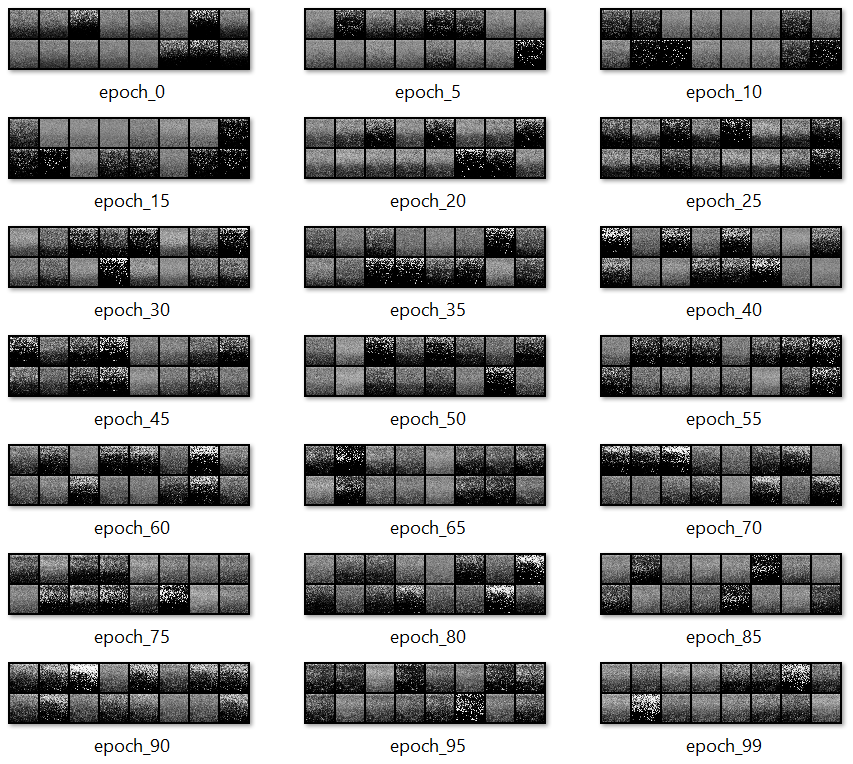

**Tensorboard Charts**

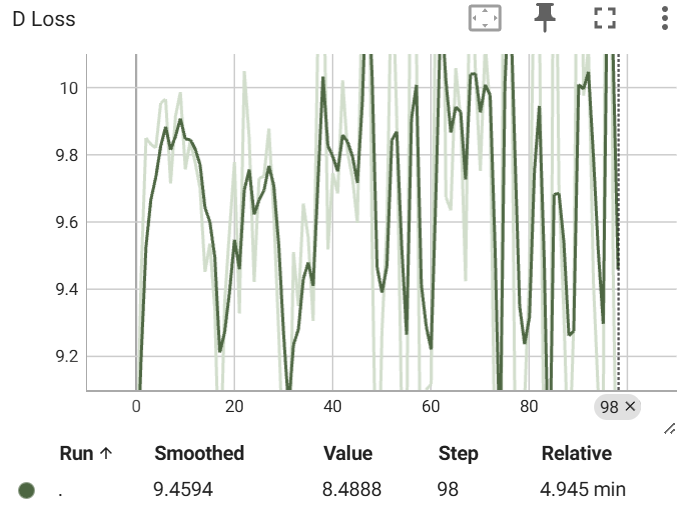

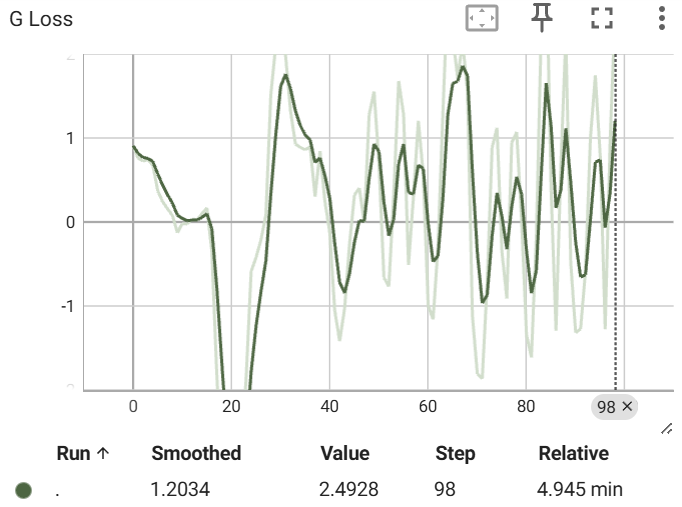

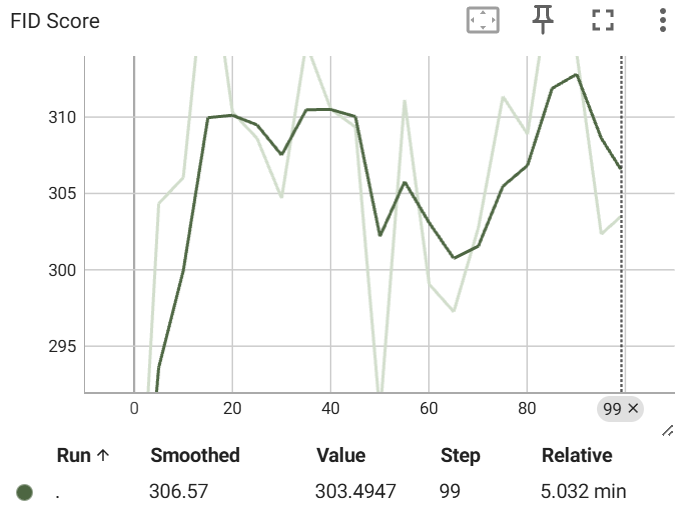

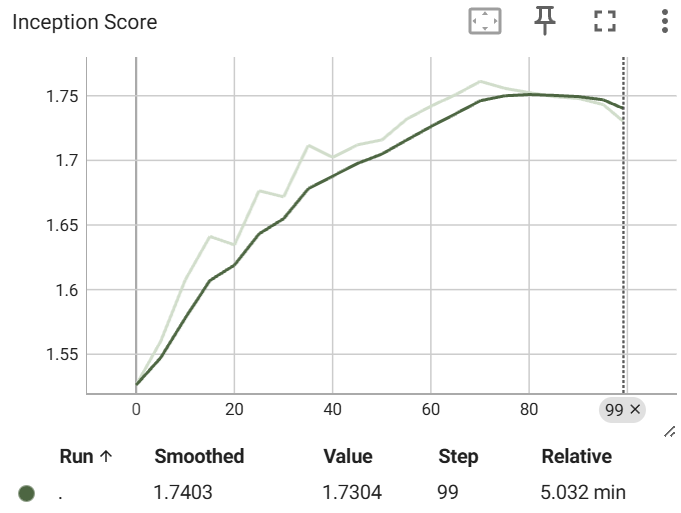

In [39]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [40]:
# Get the latest event file
event_files = [f for f in os.listdir(log_dir) if "events.out.tfevents" in f]
event_files.sort()
event_file = os.path.join(log_dir, event_files[-1])  # Last event file

# Load TensorBoard logs
event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

# Extract FID and IS values
fid_values = event_acc.Scalars("FID Score") if "FID Score" in event_acc.Tags()['scalars'] else []
is_values = event_acc.Scalars("Inception Score") if "Inception Score" in event_acc.Tags()['scalars'] else []

# Get the final recorded values
final_fid = fid_values[-1].value if fid_values else "Not Found"
final_is = is_values[-1].value if is_values else "Not Found"

print(f"Final FID: {final_fid}")
print(f"Final IS: {final_is}")

Final FID: 303.49468994140625
Final IS: 1.7304490804672241


The final **FID of 303.49** and **Inception Score (IS) of 1.73** suggest that the generated images exhibit **moderate realism** but still **lack diversity and structural fidelity**. The relatively high FID indicates a noticeable gap between generated and real distributions, implying that the model struggles with fine-grained details. The low IS reflects limited sample diversity, suggesting mode collapse or insufficient feature variation. Refining training stability, adjusting hyperparameters, or employing architectural improvements like spectral normalization or self-attention could enhance generation quality.

In [41]:
torch.save(generator.state_dict(), "generator_wgan_gp_bm100.pth")
torch.save(discriminator.state_dict(), "discriminator_wgan_gp_bm100.pth")

**As WGAN had the lowest FID and highest IS, we can conclude that, compared to LSGAN and WGAN-GP with the same architecture and same number of epochs, it had the most realistic and diverse generated images.**